In [1]:
# линейная регрессия
import pandas as pd                                   # для работы с датафреймом
import numpy as np                                    # для вычислений
import seaborn as sns                                 # для графиков
import matplotlib.pyplot as plt                       # для графиков
import statsmodels.api as sm                          # для статистического анализа
from scipy import stats                               # статистический анализ
from mlxtend.evaluate import permutation_test         # перестановочный тест

from sklearn.model_selection import train_test_split  # для деления на обучающую и тестовую выборки
from sklearn.impute import SimpleImputer              # для заполнения пропусков
from sklearn.preprocessing import OneHotEncoder       # для кодирования категориальных переменных
from sklearn.pipeline import Pipeline                 # для обработки данных для машинного обучения
from sklearn.preprocessing import StandardScaler      # стандартизация данных
from sklearn.compose import ColumnTransformer         # для обработки данных для машинного обучения


In [2]:
# ! pip install pingouin --upgrade

In [3]:
import pingouin as pg               # для статистического анализа

С линейной регрессией мы изучим три подхода:  

1. визуальный
2. статистический
3. машинное обучение

Важно помнить, что всегда предпочтительнее искать самый простой способ решения задачи. Если линейная регрессия будет хорошо справляться,  
то использовать более сложные способы не надо. Если эти сложные способы дадут незначительное улучшение, то не стоит их использовать, если  
это приводит к излишней трате вычислительного времени. Поэтому более сложные методы мы можем использовать, если 1) регрессия к нашей задаче  
не подходит, 2) другой метод не только лучше себя показывает, но и эффективнее.

# Загрузка данных

In [4]:
# загрузка данных и исправление типа данных
db = pd.read_csv('data/books_tidy_data.csv', parse_dates=['publication_date'], dtype={'decade':'object', 'quarter':'object', 'tra_co':'object'})

In [5]:
# удалим признаки, которые не будем рассматривать далее
db = db.drop(['title', 'publication_date', 'authors', 'language_code', 'publisher'], axis=1)

In [6]:
db.head()

average_rating  num_pages  ratings_count  text_reviews_count decade  \
0            4.57        652        2095690               27591   2000   
1            4.49        870        2153167               29221   2000   
2            4.42        352           6333                 244   2000   
3            4.56        435        2339585               36325   2000   
4            4.78       2690          41428                 164   2000   

  quarter tra_co  
0       3      1  
1       3      1  
2       4      0  
3       2      1  
4       3      1

In [7]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   average_rating      10838 non-null  float64
 1   num_pages           10838 non-null  int64  
 2   ratings_count       10838 non-null  int64  
 3   text_reviews_count  10838 non-null  int64  
 4   decade              10838 non-null  object 
 5   quarter             10838 non-null  object 
 6   tra_co              10838 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 592.8+ KB


In [8]:
# обзор основных характеристик
db.describe()

average_rating     num_pages  ratings_count  text_reviews_count
count    10838.000000  10838.000000   1.083800e+04        10838.000000
mean         3.942158    344.175217   1.834788e+04          553.074737
std          0.295387    238.556381   1.138660e+05         2599.330244
min          1.000000     11.000000   0.000000e+00            0.000000
25%          3.770000    203.000000   1.170000e+02           10.000000
50%          3.960000    304.000000   8.035000e+02           49.000000
75%          4.130000    417.000000   5.226750e+03          248.000000
max          5.000000   6576.000000   4.597666e+06        94265.000000

# Визуальный подход

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

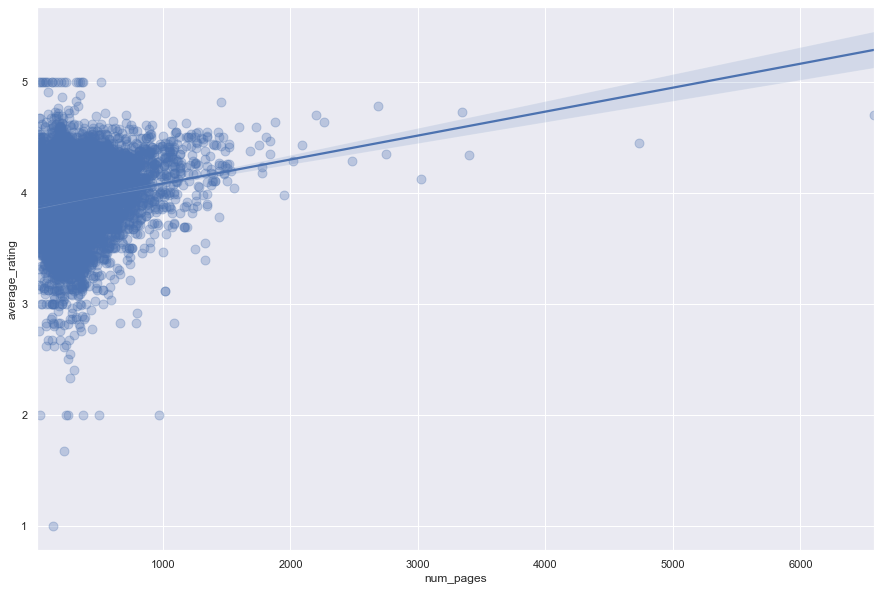

In [9]:
# задаем стиль графика
sns.set_theme(color_codes=True)
# устанавливаем размер графика
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s': 80, 'alpha': 0.3})

Интерпретация графика: точка пересечения линии регрессии с осью Y находится в районе 3.9 (в данном случае это не имеет значения, так как в этой точке X принимает значение 0, а книг с таким количеством страниц не бывает). Наклон линии говорит о том, что num_pages оказывает влияние на оценку. Наклон положительный, то есть чем больше страниц, тем выше оценка. 

Рассмотрим дополнительные техники построения графиков линейной регрессии. Начнем с полиномиальной регрессии.

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

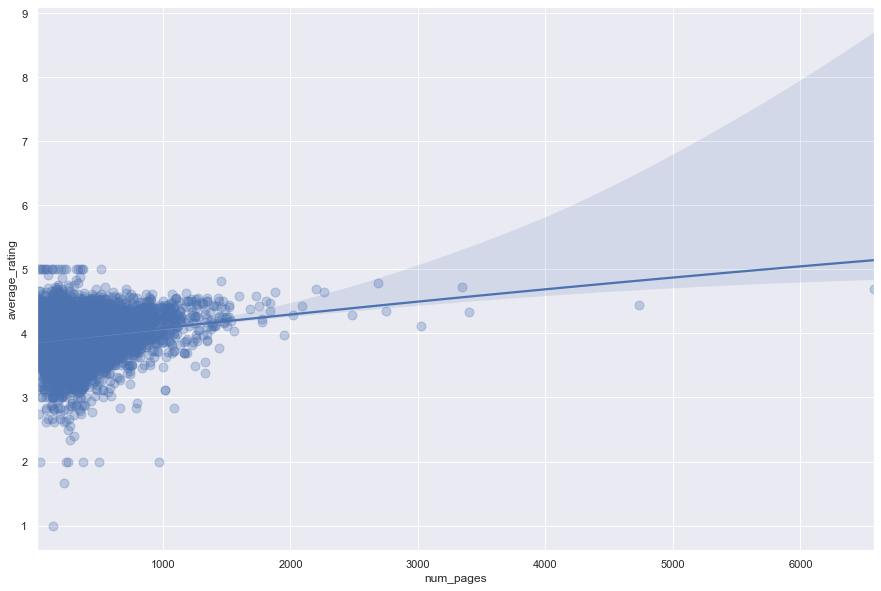

In [10]:
 fig, ax = plt.subplots(figsize=(15,10))
 # полиномиальная регрессия
 sns.regplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s':80, 'alpha':0.3}, order=2)

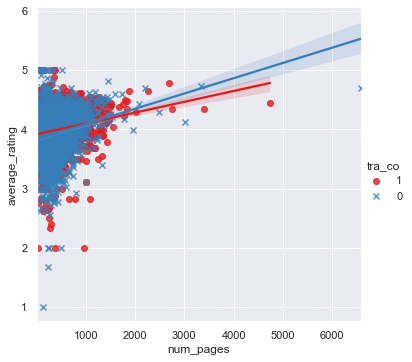

In [11]:
# регрессия с третьим признаком, который задан цветом
sns.lmplot(x='num_pages', y='average_rating', hue='tra_co', data=db, markers=["o", "x"], palette="Set1")

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

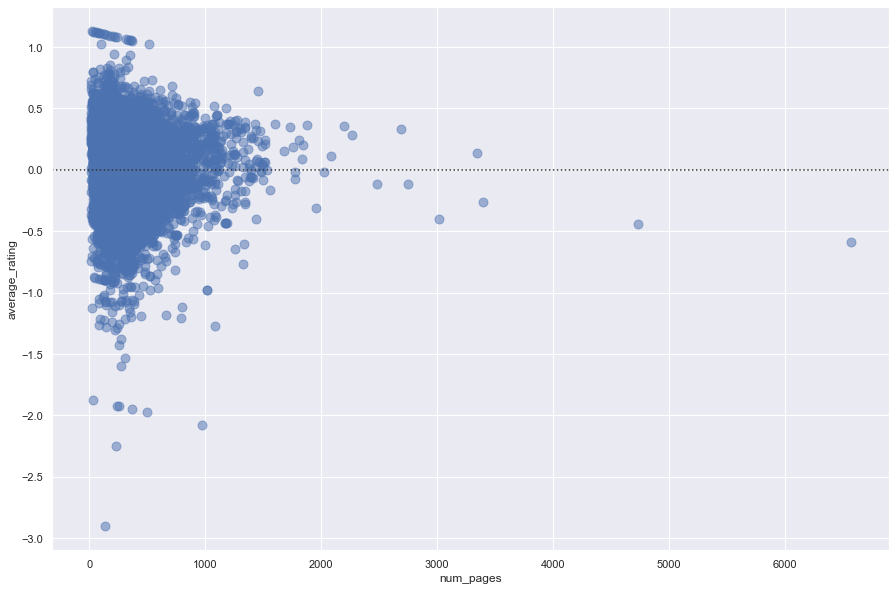

In [12]:
 fig, ax = plt.subplots(figsize=(15,10))
 # график остатков
 sns.residplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s':80, 'alpha':0.5})

Интерпретация графика. Разброс ошибок должен быть одинаков вдоль оси X. Это значит, что разница между самой болбшой и самой маленкьой ошибкой для каждого значения X должна быть одинакова на всем протяжении оси X. В нашем случае это не так. Например, в районе 0-100 по X мы видим, что разрывы между наибольшей и наименьшей ошибкой больше, чем в районе 1000-2000.

# Статистический анализ  
Статистический анализ проведем с помощью библиотеки statsmodels. Данная библиотека дает широкий вывод оценок модели, что позволяет проверить допущения линейной регрессии. Линейная регрессия, как и многие другие статистические методы, требуют наличия определенных условий для применения. Условия следующие:  
- целевой признак - непрерывная величина, независимая - может быть непрерывной или категориальной переменной;
- оценка одной книги не зависит от оценки другой - так что целевой признак независим;
- линейность отношений - мы видели, что это слабо выполняется для num_pages, но предположим, что как для этого признака,так и для остальных это выполняется;
- непрерывные переменные должны быть нормально распределены и не должны иметь выбросов, нам уже известно, что данные не распределены нормально;
- гомоскедастичность, то есть постоянство ошибок предсказания модели. Это проверяется после построения модели;
- нормальность распределения ошибок - также проверяется после построения модели;
- если мы применяем два и более признака, то необходима проверка на мультиколлинеарность, это тоже проверяется после построения модели.

#  Проверка условий для применения линейной регрессии

In [13]:
# применим тест Шапиро для проверки данных на нормальность распределения
pg.normality(db['average_rating'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W          pval  normal
average_rating  0.973475  1.377196e-40   False

In [14]:
pg.normality(db['num_pages'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W  pval  normal
num_pages  0.771622   0.0   False

In [15]:
pg.normality(db['ratings_count'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W  pval  normal
ratings_count  0.127581   0.0   False

In [16]:
pg.normality(db['text_reviews_count'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W  pval  normal
text_reviews_count  0.180052   0.0   False

Тест показывает, что данные не распределены нормально. В этом случае можно преобразовать данные или удалить выбросы.  
Сначала удалим выбросы, проверим данные на нормальность, если это не поможет, то преобразуем данные.  
Мы можем не только удалить выбросы, но и сделать их самостоятельным объектом исследования. На практике удаление выбросов это крайняя мера (?).

In [17]:
# удалим выбросы
for x in ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']:
    q1, q3 = np.percentile(db[x], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    db = db.loc[(db[x] < upper_bound) & (db[x] > lower_bound)]

/Users/Shared/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


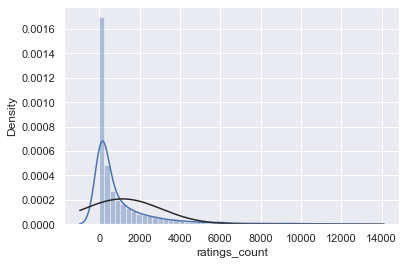

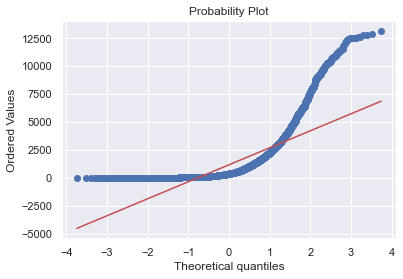

In [18]:
# проверим на нормальность
from scipy.stats import norm # пример скошенных данных на графике
sns.distplot(db['ratings_count'], fit=norm)
fig = plt.figure() 
res = stats.probplot(db['ratings_count'], plot=plt) # получаем практически нормально распределение

In [19]:
# данные незначительно скошены влево
db['average_rating'].skew()

-0.11276716804191525

In [20]:
# данные скошены вправо
db['num_pages'].skew()

0.55195724170108

In [21]:
# данные скошены вправо
db['ratings_count'].skew()

2.8605237582010004

In [22]:
# данные скошены вправо
db['text_reviews_count'].skew()

1.5563535725435345

Скошенность для средней оценки небольшая, поэтому не будем ее преобразовывать.  
Для скошенности вправо подходит преобразование через логарифм. Логарифмирование позволяет большие значения в наборе приблизить к центру

In [23]:
# пример преобразования через логарифм 
a = 0.001 # преобразование к нормальному
num_pages_log = np.log(db['num_pages'] + a) # логарифм
num_pages_log.skew()


-1.255890076353213

 Видим, что преобразование не помогло, поэтому не будем преобразовывать наши данные.

 # Построение линейной регрессии